In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys


%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 5]

In [2]:


def load_cross_validation_result2(metrics_root_dir, experiment_name, metric, tolorance=0, group_sep="\n"):
  bert_crossvalidation_metrics = f"{metrics_root_dir}/{experiment_name}/crossval_metrics.csv"

  if not os.path.exists(bert_crossvalidation_metrics):
      print(f"File not found: {bert_crossvalidation_metrics}")

  nice_label_dict = {
              "NO_SP": "Other",
              "SP": "Sec/SPI",
              "LIPO": "Sec/SPII",
              "TAT": "Tat/SPI",
              "TATLIPO": "Tat/SPII",
              "PILIN": "Sec/SPIII",
              None: None,
              np.nan: None
          }

  metrics_df = pd.read_csv(bert_crossvalidation_metrics, index_col=0)
  df_plot = metrics_df.astype(float).mean(axis=1)

  metrics_df = pd.DataFrame({"Bert": df_plot})
  info_df = metrics_df.reset_index()["index"].str.split("_", expand=True)
  info_df.columns = ["kingdom", "type", "metric", "no", "window"]
  info_df.index = metrics_df.index

  metrics_df = metrics_df.join(info_df)
  metrics_df["type"] = metrics_df["type"].apply(lambda x: nice_label_dict[x])

  df_plot = metrics_df.loc[metrics_df["kingdom"].isin(["ARCHAEA", "EUKARYA", "POSITIVE", "NEGATIVE"])]

  if metric in ["recall", "precision"]:
    df_plot = df_plot.loc[(df_plot["metric"] == metric) & (df_plot["window"] == str(tolorance))]
  else:
    df_plot = df_plot.loc[df_plot["metric"] == metric]


  df_plot = df_plot.loc[df_plot["metric"] == metric][["kingdom", "type", "Bert"]]
  df_plot = df_plot.set_index(df_plot["kingdom"].str.capitalize() + group_sep + df_plot["type"])
  df_plot = df_plot.sort_index()

  df_plot = df_plot.rename({"crossval_mean": "Bert-CRF"}, axis=1)
  
  return df_plot


def all_models_performance_mean(merged_data_df, baseline_name = "FineTune"):
    mean_df = merged_data_df.groupby('setting')['value'].mean().to_frame()
    mean_df = mean_df.reset_index()
    
    mean_df = mean_df.round(3)
    mean_df = mean_df.sort_values(by=['value'], ascending=False)
    
    performance_dict = {}
    for _, row in mean_df.iterrows():
        performance_dict[row['setting']] = row['value']
    
    title_performance_str = ""
    for k, v in performance_dict.items():
        title_performance_str += f"{k}: {v} / "
    
    return performance_dict, title_performance_str
  
  
def get_performance(baseline_dir, baseline_name, baseline_experiment_name, method_dir, metric, tolerance=0):

  data_list = []
  baseline_experiment_name = ""
  baseline_df = load_cross_validation_result2(baseline_dir, baseline_experiment_name, metric, tolerance)
  baseline_df["setting"] = baseline_name
  data_list.append(baseline_df)

  for experiment_name in os.listdir(method_dir):
      
      if 'skip' in experiment_name:
          continue
      
      if not os.path.isdir(os.path.join(method_dir, experiment_name)):
          continue
      
      data_df = load_cross_validation_result2(method_dir, experiment_name, metric, tolerance)
      if data_df is None:
          continue
      
      data_df["setting"] = experiment_name
      data_list.append(data_df)

  merged_data_df = pd.concat(data_list)

  merged_data_df = merged_data_df.reset_index().rename(columns={"index":"sp_type"})
  merged_data_df = merged_data_df.rename(columns={"Bert": "value"})
  merged_data_df = merged_data_df.round(3)

  return merged_data_df


def prepare_butterfly_data(precision_df, recall_df):
  factors = precision_df.sp_type.unique().tolist()

  precision_dict = {}
  for idx, group in precision_df.groupby(['setting']):
    group.value = group.value * -1
    precision_dict[idx] = group.value.tolist()

  recall_dict = {}
  for idx, group in recall_df.groupby(['setting']):
    recall_dict[idx] = group.value.tolist()
    
  return factors, precision_dict, recall_dict


<Figure size 1200x500 with 0 Axes>

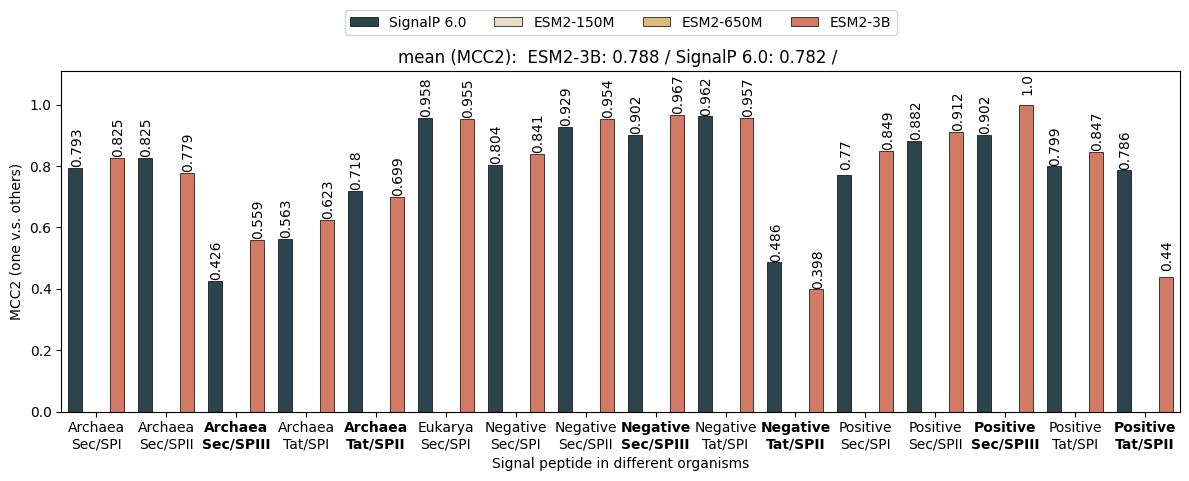

In [3]:
plt.clf()
plt.figure()

figure_dpi = 600

metric = "mcc2"
data_list = []

# baseline_dir = "testruns_results/baseline/ex_signalP_finetune_DS30"
baseline_dir = "testruns_results/baseline/SignalP 6.0"
baseline_experiment_name = ""
baseline_name = "SignalP 6.0"

## models
method_dir = "testruns_results/Reproduce/LoRA"
merged_data_df = get_performance(baseline_dir, baseline_name, baseline_experiment_name, method_dir, metric, 0)


models_performance, models_performance_str = all_models_performance_mean(merged_data_df, baseline_name)


order_list = ['SignalP 6.0', 'ESM2-150M', 'ESM2-650M', 'ESM2-3B']
order_list = ['SignalP 6.0', 'ESM2-150M', 'ESM2-650M', 'ESM2-3B',]
# order_list = ['SignalP 6.0', 'test', 'val']
colors = ['#264653', '#edddc3', '#eebf6d', '#e66f51', "black", "red", "yellow", "blue"]

ax = sns.barplot(x='sp_type', y='value', hue='setting', data=merged_data_df, 
                 hue_order=order_list, palette=colors, edgecolor='black', linewidth=0.5)


plt.title("mean (MCC2):  " + models_performance_str)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.ylabel("MCC2 (one v.s. others)")
plt.ylim(0, 1.11)
plt.xlabel("Signal peptide in different organisms")
plt.tight_layout()


# Highlight specific x-axis labels in red color
labels = ax.get_xticklabels()
for label in labels:
    if "SPIII" in label.get_text():
        # label.set_color('blue')
        label.set_fontweight('bold')
    if "Tat/SPII" in label.get_text():
        # label.set_color('red')   
        label.set_fontweight('bold')

## Adding values in the top of bar.
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(1, 15), textcoords='offset points', rotation=90)



plt.savefig(os.path.join(method_dir, f"summary_{metric}.png"), dpi=figure_dpi)

<Figure size 1200x500 with 0 Axes>

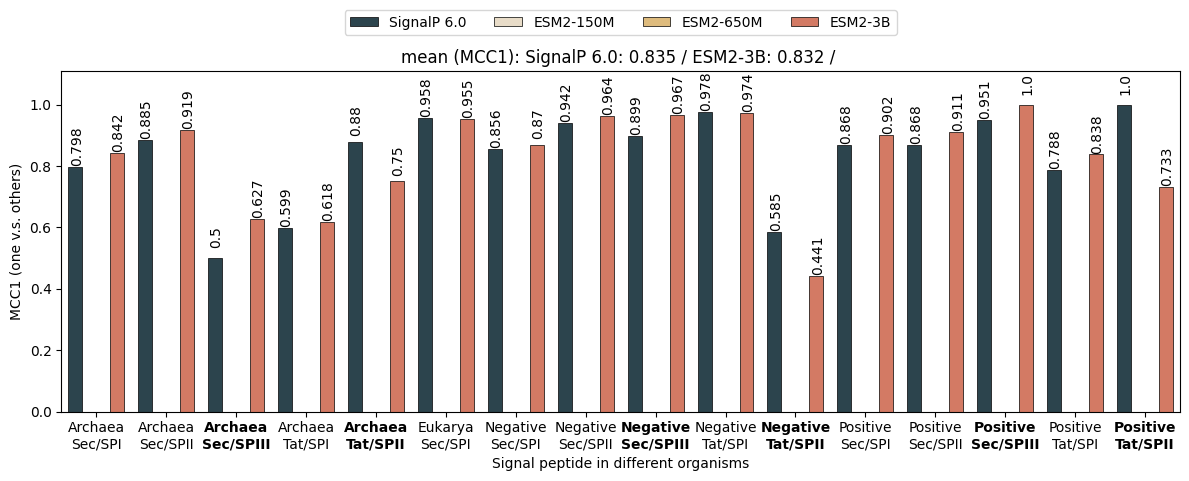

In [4]:
plt.clf()
plt.figure()


metric = "mcc1"
data_list = []

## models
merged_data_df = get_performance(baseline_dir, baseline_name, baseline_experiment_name, method_dir, metric, 0)

models_performance, models_performance_str = all_models_performance_mean(merged_data_df, baseline_name)


ax = sns.barplot(x='sp_type', y='value', hue='setting', data=merged_data_df, 
                 hue_order=order_list, palette=colors, edgecolor='black', linewidth=0.5)
plt.title("mean (MCC1): " + models_performance_str)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.ylabel("MCC1 (one v.s. others)")
plt.ylim(0, 1.11)
plt.xlabel("Signal peptide in different organisms")
plt.tight_layout()


# Highlight specific x-axis labels in red color
labels = ax.get_xticklabels()
for label in labels:
    if "SPIII" in label.get_text():
        # label.set_color('blue')
        label.set_fontweight('bold')
    if "Tat/SPII" in label.get_text():
        # label.set_color('red')   
        label.set_fontweight('bold')


for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(1, 15), textcoords='offset points', rotation=90)


plt.savefig(os.path.join(method_dir, f"summary_{metric}.png"), dpi=figure_dpi)

/tmp/ipykernel_2656309/1910538383.py:100: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, group in precision_df.groupby(['setting']):
/tmp/ipykernel_2656309/1910538383.py:105: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for idx, group in recall_df.groupby(['setting']):
/tmp/ipykernel_2656309/2510220564.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "1.0", "0.75", "0.5", "0.25", "0", "0.25", "0.5", "0.75", "1.0"])


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

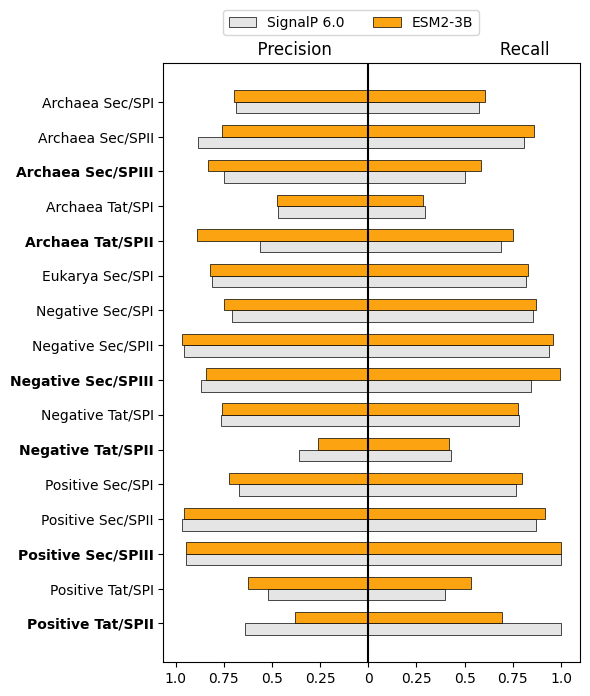

In [5]:


precision_df = get_performance(baseline_dir, baseline_name, baseline_experiment_name, method_dir, "precision", 0)
recall_df = get_performance(baseline_dir, baseline_name, baseline_experiment_name, method_dir, "recall", 0)
factors, precision_dict, recall_dict = prepare_butterfly_data(precision_df, recall_df)
factors = [item.replace("\n", " ") for item in factors]

model_names = precision_df.setting.unique().tolist()

for model_name in model_names:
  
  if model_name == baseline_name:
    continue
  
  plt.clf()
  plt.figure()
  
  precision_list = []
  recall_list = []
  order_list = [baseline_name, model_name]
  
  for model_name in order_list:
    precision_list.append(precision_dict[model_name])
    recall_list.append(recall_dict[model_name])


  # Data for the Butterfly Chart with multiple groups in the same plot
  groups = ['Precision', 'Recall']

  positive_impact = precision_list
  negative_impact = recall_list

  # Create a single plot for all groups
  fig, ax = plt.subplots(figsize=(6, 7))

  bar_width = 0.5 # Width of each bar
  index = np.arange(len(factors), 0, -1)  # Index for the x-axis positions
  index = index * 1.5

  color_map = {0: "#e5e5e5", 1: "#fca311"}
  # Create Butterfly Chart for each group
  for i, group in enumerate(groups):
      color = color_map[i]
      left_bars = ax.barh((index + i * bar_width), positive_impact[i], bar_width, label=f'Positive - {group}', 
                          color=color, edgecolor='black', linewidth=0.5)
      right_bars = ax.barh((index + i * bar_width), negative_impact[i], bar_width, label=f'Negative - {group}', 
                           color=color, edgecolor='black', linewidth=0.5)

  center_line = 0  # X-coordinate for the center line
  # Add a vertical line at the center

  # Set labels, title, and legend
  ax.set_yticks((index + bar_width * (len(groups) - 1) / 2))
  ax.set_yticklabels(factors)
  ax.set_title('                  Precision                                Recall', loc='left')
  # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

  ax.axvline(x=center_line, color='black', linestyle='-', label='Center Line')


  # Highlight specific x-axis labels in red color
  labels = ax.get_yticklabels()
  for label in labels:
      if "SPIII" in label.get_text():
          # label.set_color('blue')
          label.set_fontweight('bold')
      if "Tat/SPII" in label.get_text():
          # label.set_color('red')   
          label.set_fontweight('bold')

  # # Get the x-axis tick labels
  # xtick_labels = ax.get_xticklabels()
  # for label in xtick_labels:
  #   value = abs(float(label.get_text().replace('−', '-')))
  #   label.set_text("AAAA")
    
  ax.set_xticklabels(["", "1.0", "0.75", "0.5", "0.25", "0", "0.25", "0.5", "0.75", "1.0"])

  handles, labels = plt.gca().get_legend_handles_labels()
  new_labels = []
  for h, l in zip(handles, labels):
    if "Negative" in l:
      continue
    if "Precision" in l:
      new_labels.append((h, baseline_name))
    if "Recall" in l:
      new_labels.append((h, model_name))

  handles, labels = zip(*new_labels)
  plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.45, 1.1), ncol=2)

  # Adjust spacing
  plt.tight_layout()

  # Show the chart
  plt.show()

  fig.savefig(os.path.join(method_dir, model_name, f"summary_precision_recall.png"), dpi=figure_dpi)